                        
# Trabalho de Inteligencia Artificial - Classifição de Texto (TF-IDF)

## Definindo Tarefa, Desempenho e Experiencia

- Tarefa: Classificação de texto em (Suícida e Não Suícida)
- Desempenho: Iremos avaliar utilizando um conjunto de metricas: precision, recall, f1 e ROC 
- Experiencia: (https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch/data)

---------

## Imports e definição do DataFrame 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import nltk
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
import tensorflow as tf

In [2]:
df = pd.read_csv("datasets/Classification/Corona_NLP_train.csv",encoding='latin-1')

--------

 ## Estudo a respeito da nossa base de dados: 


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [4]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
df['Sentiment'].value_counts()

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [6]:
df = df.drop(columns=[ "UserName","ScreenName","Location","TweetAt"], axis=1)

In [7]:
def categorize_sentiment(score):
    if score == 'Negative':
        return "Negative"
    elif score == 'Extremely Negative':
        return "Negative"
    elif score == 'Positive':
        return "Positive"
    elif score == 'Extremely Positive':
        return "Positive"
    else:
        return "Neutral"
    
    
df['Sentiment'] = df['Sentiment'].apply(categorize_sentiment)

In [8]:
# df['label'] = df.label.map({'Detractor':0, 'Promoter':1, 'Passive':2})

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

colunas_categoricas = ['Sentiment']

one_hot_enc = make_column_transformer((OneHotEncoder(handle_unknown = 'ignore'),colunas_categoricas),remainder='passthrough')


df = one_hot_enc.fit_transform(df)
df = pd.DataFrame(df, columns=one_hot_enc.get_feature_names_out())
df

,onehotencoder__Sentiment_Negative,onehotencoder__Sentiment_Neutral,onehotencoder__Sentiment_Positive,remainder__OriginalTweet
0,0.0,1.0,0.0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1,0.0,0.0,1.0,advice Talk to your neighbours family to excha...
2,0.0,0.0,1.0,Coronavirus Australia: Woolworths to give elde...
3,0.0,0.0,1.0,My food stock is not the only one which is emp...
4,1.0,0.0,0.0,"Me, ready to go at supermarket during the #COV..."
...,...,...,...,...
41152,0.0,1.0,0.0,Airline pilots offering to stock supermarket s...
41153,1.0,0.0,0.0,Response to complaint not provided citing COVI...
41154,0.0,0.0,1.0,You know itÂs getting tough when @KameronWild...
41155,0.0,1.0,0.0,Is it wrong that the smell of hand sanitizer i...


In [9]:
df.onehotencoder__Sentiment_Negative = pd.to_numeric(df.onehotencoder__Sentiment_Negative)
    

df.onehotencoder__Sentiment_Neutral = pd.to_numeric(df.onehotencoder__Sentiment_Neutral)
    

df.onehotencoder__Sentiment_Positive = pd.to_numeric(df.onehotencoder__Sentiment_Positive)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   onehotencoder__Sentiment_Negative  41157 non-null  float64
 1   onehotencoder__Sentiment_Neutral   41157 non-null  float64
 2   onehotencoder__Sentiment_Positive  41157 non-null  float64
 3   remainder__OriginalTweet           41157 non-null  object 
dtypes: float64(3), object(1)
memory usage: 1.3+ MB


Primeiro, devemos definir as stopwords

In [11]:
nltk.download('stopwords')
stemmer = PorterStemmer()
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Logo, é criado uma função que define como sera a saida para cada frase

Alocamos em uma variavel os valores dos rotulos e das features (txt)

In [12]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def get_all_str(tweet):
    sentence = ''
    for words in tweet:
        sentence += words
    sentence = sentence.lower()
    return sentence
def get_str(lst):
    sentence = ''
    for char in lst:
        sentence += char+' '
    sentence = sentence.lower()
    return sentence

def get_word(text): 
    result = nltk.RegexpTokenizer(r'\w+').tokenize(text.lower())
    return result

def get_hashtag(text):
    result = nltk.RegexpTokenizer(r'(?<=#)\w+').tokenize(text.lower())
    return result

def get_mention(text):
    result = nltk.RegexpTokenizer(r'(?<=@)\w+').tokenize(text.lower())
    return result 

def stopword_list(stop):
    lst = stopwords.words('english')
    for stopword in stop:
        lst.append(stopword)
    return lst

def remove_stopword(stopwords, lst):    
    stoplist = stopword_list(stopwords)
    txt = ''
    for idx in range(len(lst)):
        txt += lst[idx]
        txt += '\n'
    cleanwordlist = [word for word in txt.split() if word not in stoplist] 
#     print(stoplist)
    return cleanwordlist

def pos_remove_noun(tagged):
    remove_noun = [word for word,pos in tagged if pos not in ['NN','NNS','NNP','NNPS']]
    txt = ''
    for i in range(len(remove_noun)):
        txt += remove_noun[i]
        txt += '\n'
    return cleanwordlist

def lemmatization(words):
    lemm = WordNetLemmatizer()
    tokens = [lemm.lemmatize(word) for word in words]
#     txt= ' '.join(tokens)
    return tokens

In [13]:
def textPreprocessor(featureRecord):
    #Remove punctuations
    removePunctuation = [char for char in featureRecord if char not in string.punctuation]
    sentences =''.join(removePunctuation)

    #convert sentences to words
    words = sentences.split(" ")

    #normalize
    wordNormalized=[word.lower() for word in words]

    #remove stropwords
    finalWords=[word for word in wordNormalized if word not in stopwords.words("english")]

    finalWords = [stemmer.stem(word) for word in finalWords]

    #joined = ' '.join(finalWords)

    return finalWords

textPreprocessor("We need to STOCK UP in anticipation of a possible response or directive related to COVID-19 so we've created a SPECIFIC Amazon Wishlist.\r\r\n.\r\r\nFOOD Items include: black beans, shredded cheese, frozen meats, canned tuna,\x85 https://t.co/NZAoPtKliy")

['need',
 'stock',
 'anticip',
 'possibl',
 'respons',
 'direct',
 'relat',
 'covid19',
 'weve',
 'creat',
 'specif',
 'amazon',
 'wishlist\r\r\n\r\r\nfood',
 'item',
 'includ',
 'black',
 'bean',
 'shred',
 'chees',
 'frozen',
 'meat',
 'can',
 'tuna\x85',
 'httpstconzaoptkliy']

In [14]:
#ML Preprocessing
df_frac = df.sample(frac=0.20, random_state=42)
# df_frac = df.sample(frac=0.20, random_state=42) <-
label = df_frac.iloc[:,0:3].values
txt = df_frac.iloc[:,3].values
txt

array([' Without the there would not be any problem whatsoever People are getting worried about the supply chain   Prices for key food staples are starting to soar in some parts of the world via',
       'Rice &amp; wheat prices surge amid fears Covid-19 lockdown may threaten global food security\r\r\nIncreased panic buying of food due to coronavirus lockdowns has led to price spikes for  worldÂ\x92s two staple grains, rice&amp; wheat. Importers rushed to stockpile goods\r\r\n https://t.co/0qOv3jAp9m',
       "When the government says to start social distancing, but you work retail so you can't just not talk to customers in the store lol fml I'm 100% going to catch covid-19",
       ...,
       'I can pretty much guarantee it s going to be healthcare workers and grocery store folks non profits delivery people and the like who are going to save your ass during the pandemic and not the Kardashians',
       'No grooming. No eating out. No online shopping. IÂ\x92m back in my early 20Â\x92s

Ralizamos o pré-processamento da feature e fazemos a contagem da frequencia de cada termo do corpus

In [15]:
#Create Bag Of Words 

#Initialize Count Vectorizer with our custom preprocessing function

wordVector = CountVectorizer(analyzer=textPreprocessor)

#Build Vocab
finalWordVocab = wordVector.fit(txt)

In [16]:
finalWordVocab.vocabulary_

{'': 0,
 'without': 24866,
 'would': 25006,
 'problem': 19324,
 'whatsoev': 24700,
 'peopl': 18589,
 'get': 8828,
 'worri': 24987,
 'suppli': 22547,
 'chain': 4452,
 'price': 19211,
 'key': 15075,
 'food': 8287,
 'stapl': 22034,
 'start': 22044,
 'soar': 21666,
 'part': 18425,
 'world': 24965,
 'via': 24241,
 'rice': 20283,
 'amp': 2478,
 'wheat': 24704,
 'surg': 22594,
 'amid': 2462,
 'fear': 7982,
 'covid19': 5647,
 'lockdown': 15724,
 'may': 16278,
 'threaten': 23159,
 'global': 8918,
 'security\r\r\nincreas': 20975,
 'panic': 18331,
 'buy': 4034,
 'due': 7091,
 'coronaviru': 5346,
 'led': 15457,
 'spike': 21879,
 'worldâ\x92': 24983,
 'two': 23709,
 'grain': 9108,
 'riceamp': 20285,
 'import': 14206,
 'rush': 20533,
 'stockpil': 22214,
 'goods\r\r\n': 9020,
 'httpstco0qov3jap9m': 9997,
 'govern': 9069,
 'say': 20797,
 'social': 21674,
 'distanc': 6752,
 'work': 24922,
 'retail': 20192,
 'cant': 4199,
 'talk': 22738,
 'custom': 6075,
 'store': 22265,
 'lol': 15777,
 'fml': 8260,
 'i

Ao final, obtivemos 69473 termos distintos 

In [17]:
len(finalWordVocab.vocabulary_)

25571

Apos isso, se é construído o Bag of Words

In [18]:
#Create Bag Of Words

bagOfWords = finalWordVocab.transform(txt)

bagOfWords

<8231x25571 sparse matrix of type '<class 'numpy.int64'>'
	with 150042 stored elements in Compressed Sparse Row format>

Por fim, é aplicado as contas de TFIDF no bag of words, armazenando na variavel finalFeature

In [19]:
#Apply TFIDF on Bag Of Words

#Calc All Values (TF and IDF)

tfIdfObject = TfidfTransformer().fit(bagOfWords)

#Transform data (Calc Weights)
finalFeature = tfIdfObject.transform(bagOfWords)

finalFeature

<8231x25571 sparse matrix of type '<class 'numpy.float64'>'
	with 150042 stored elements in Compressed Sparse Row format>

In [20]:
X_traint, X_testt, y_traint, y_testt = train_test_split(finalFeature, label, test_size=0.2, random_state=42)

X_traint, X_validt, y_traint, y_validt = train_test_split(X_traint, y_traint, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


In [21]:
from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE()
finalFeature, label = oversample.fit_resample(finalFeature, label)

In [22]:
# X_train, X_test, y_train, y_test = train_test_split(finalFeature, label, test_size=0.3, random_state=53)
X_train, X_test, y_train, y_test = train_test_split(finalFeature, label, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


In [23]:
y_valid

array([[0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0]])

In [24]:
y_train

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0]])

-----

In [25]:
X_train = X_train.toarray()
X_valid = X_valid.toarray()

In [26]:
type(X_valid)

numpy.ndarray

## Estudo do PCA

In [27]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD


pca = PCA(n_components=2)
PCA = pca.fit(finalFeature.toarray())
X_pca = pca.transform(finalFeature.toarray())

# clf = TruncatedSVD()
# pca = clf.fit_transform(X_train)

# pca = pd.DataFrame(pca)

# X_pca.rename(columns={0: 'x', 1: 'y'}, inplace = True)



X_pca


array([[ 0.24136088, -0.05060125],
       [-0.00031122, -0.08589163],
       [-0.05049986,  0.1210936 ],
       ...,
       [-0.04688038, -0.06558108],
       [-0.0549894 , -0.10270623],
       [ 0.09817847,  0.03954987]])

-----

In [28]:
from sklearn.cluster import KMeans

kmeanModel = KMeans(n_clusters=3)
kmeanModel.fit(X_pca)
pred_labels = kmeanModel.labels_
pred_centers = kmeanModel.cluster_centers_
df_centers = pd.DataFrame(pred_centers, columns=['x', 'y'])
df_centers.head(1)

dfcl = pd.DataFrame(columns=['x','y','label'])
dfcl['x'] = X_pca[:,0]
dfcl['y'] = X_pca[:,1]
dfcl['label'] = kmeanModel.labels_
dfcl.head(5)

c:\Users\alexa\Downloads\Dados_Pratica_04_Portarias\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,x,y,label
0,0.241361,-0.050601,1
1,-0.000311,-0.085892,0
2,-0.050500,0.121094,2
3,0.099463,-0.033971,0
4,-0.054481,-0.078099,0


In [29]:
lbl = dfcl['label']
lbl

0        1
1        0
2        2
3        0
4        0
        ..
10846    1
10847    0
10848    0
10849    0
10850    2
Name: label, Length: 10851, dtype: int32

C:\Users\alexa\AppData\Local\Temp\ipykernel_19880\531807487.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], palette='Set2')


Text(0.5, 1.0, 'scatter plot')

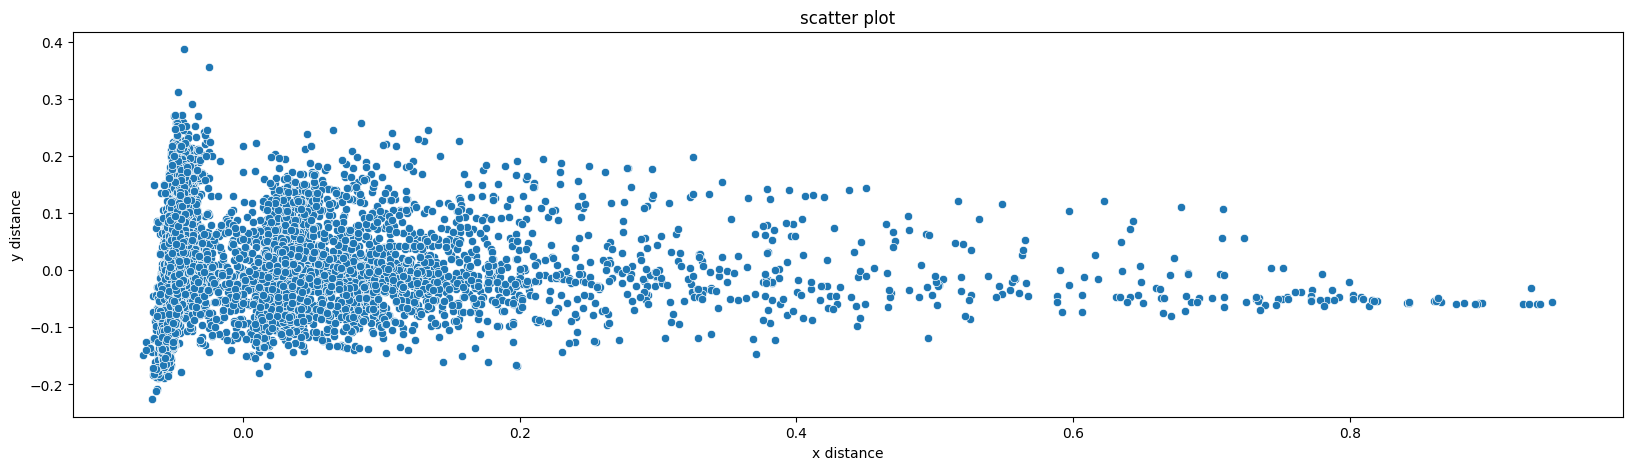

In [30]:
plt.figure(figsize=(20,5))

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], palette='Set2')

plt.xlabel('x distance')
plt.ylabel('y distance')
plt.title('scatter plot')

In [31]:
# plt.figure(figsize=(20,5))
# 
# sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=[label], palette='Set2', legend="full", )
# 
# 
# plt.xlabel('x distance')
# plt.ylabel('y distance')
# plt.title('Gráfico com rotulação')

Construindo a rede neural profunda

In [32]:
from keras.initializers import glorot_uniform

def create_model(flag): 

    n_neuronios_ocultos = 10
    # iniciador_pesos = glorot_uniform(seed=53)
    iniciador_pesos = glorot_uniform(seed=42)
    
    # tf.random.set_seed(53)
    tf.random.set_seed(42)
    model = tf.keras.Sequential()

    if flag == 1:
        model.add(tf.keras.Input(shape=X_train.shape[1:]))
        model.add(tf.keras.layers.Dense(units=n_neuronios_ocultos, activation="selu"))
        model.add(tf.keras.layers.Dense(units=n_neuronios_ocultos, activation="selu"))
        model.add(tf.keras.layers.Dense(3, activation='softmax'))
    elif flag == 2:
        model.add(tf.keras.Input(shape=X_train.shape[1:]))
        model.add(tf.keras.layers.Dense(units=n_neuronios_ocultos, activation="selu", kernel_initializer=iniciador_pesos))
        model.add(tf.keras.layers.Dense(units=n_neuronios_ocultos, activation="selu", kernel_initializer=iniciador_pesos))
        model.add(tf.keras.layers.Dense(3, activation='softmax'))
    elif flag == 3:
        model.add(tf.keras.Input(shape=X_train.shape[1:]))
        model.add(tf.keras.layers.Dense(units=n_neuronios_ocultos, activation="selu", kernel_regularizer=tf.keras.regularizers.l2()))
        model.add(tf.keras.layers.Dense(units=n_neuronios_ocultos, activation="selu", kernel_regularizer=tf.keras.regularizers.l2()))
        model.add(tf.keras.layers.Dense(3, activation='softmax'))
    elif flag == 4:
        model.add(tf.keras.Input(shape=X_train.shape[1:]))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(units=n_neuronios_ocultos, activation="selu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(units=n_neuronios_ocultos, activation="selu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(3, activation='softmax'))
    elif flag == 5:
        model.add(tf.keras.Input(shape=X_train.shape[1:]))
        model.add(tf.keras.layers.Dropout(rate=0.2))
        model.add(tf.keras.layers.Dense(units=n_neuronios_ocultos, activation="selu"))
        model.add(tf.keras.layers.Dropout(rate=0.2))
        model.add(tf.keras.layers.Dense(units=n_neuronios_ocultos, activation="selu"))
        model.add(tf.keras.layers.Dropout(rate=0.2))
        model.add(tf.keras.layers.Dense(3, activation='softmax'))
    elif flag == 6:
        model.add(tf.keras.Input(shape=X_train.shape[1:]))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(rate=0.2))
        model.add(tf.keras.layers.Dense(units=n_neuronios_ocultos, activation="selu", kernel_regularizer=tf.keras.regularizers.l2(0.1), kernel_initializer=iniciador_pesos))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(rate=0.2))
        model.add(tf.keras.layers.Dense(units=n_neuronios_ocultos, activation="selu", kernel_regularizer=tf.keras.regularizers.l2(0.1), kernel_initializer=iniciador_pesos))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(rate=0.2))
        model.add(tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.1), kernel_initializer=iniciador_pesos))
        
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    model.compile(
        optimizer=optimizer,
        # Loss function to minimize
        loss="categorical_crossentropy",
        # loss=tf.keras.losses.CategoricalHinge(),
        # List of metrics to monitor
        metrics=["accuracy"]
    )
        
    model.build()
    model.summary()
    return model

In [33]:
from keras.callbacks import LearningRateScheduler
import keras

# Define the power schedule function
def power_scheduler(epoch, initial_lr, max_epochs, power):
    return initial_lr * ((1 - epoch / max_epochs) ** power)

# Set your initial learning rate, maximum number of epochs, and power
initial_lr = 0.01
max_epochs = 100
power = 2

# Create a learning rate scheduler callback
power_schedule = LearningRateScheduler(lambda epoch: power_scheduler(epoch, initial_lr, max_epochs, power))

# Use the callback in your model training
        # model.fit(X_train, y_train, callbacks=[power_schedule])

In [34]:
from keras.callbacks import LearningRateScheduler
import numpy as np
# 
# Define the exponential schedule function
def exponential_scheduler(epoch, initial_lr, k):
    return initial_lr * np.exp(-k * epoch)
# Define the power schedule function
def power_scheduler(epoch, initial_lr, max_epochs, power):
    return initial_lr * ((1 - epoch / max_epochs) ** power)


# Set your initial learning rate and decay rate (k)
initial_lr = 0.01
k = 0.1
power = 2

# Create a learning rate scheduler callback
exp_schedule = LearningRateScheduler(lambda epoch: exponential_scheduler(epoch, initial_lr, k))




# Create a learning rate scheduler callback
power_schedule = LearningRateScheduler(lambda epoch: power_scheduler(epoch, initial_lr, max_epochs, power))

# Use the callback in your model training
# model.fit(X_train, y_train, callbacks=[power_schedule])

# Use the callback in your model training
# model.fit(X_train, y_train, callbacks=[exp_schedule])

In [35]:
import matplotlib.pyplot as plt 
import pandas as pd

def infos(model, history):
    _, accuracy = model.evaluate(X_valid, y_valid)
    
    from sklearn.metrics import confusion_matrix
    y_pred = model.predict(X_valid)
    
    macro = tf.keras.metrics.F1Score(average="macro", name='f1_score', dtype=None)
    
    micro = tf.keras.metrics.F1Score(average="micro", name='f1_score', dtype=None)
    
        
    macro.update_state(y_valid,y_pred)
    micro.update_state(y_valid,y_pred)
    print('Accuracy: %.2f' % (accuracy*100))

    print("macro = " + str((macro.result()).numpy()) + "\nmicro = " + str((micro.result()).numpy()))
        
    
    
    y_pred=np.argmax(y_pred, axis=1)
    y_valid1=np.argmax(y_valid, axis=1)
    cm = confusion_matrix(y_valid1, y_pred)
     
    
    sum = cm.sum()
    
    df_cm = pd.DataFrame(cm, index = [0, 1, 2], columns = [0, 1, 2])
    
    res = sns.heatmap(df_cm, annot=True, vmin=0.0, vmax=1000.0,  cmap=plt.cm.Blues, fmt='g')
    plt.yticks([0.5,1.5,2.5], [0, 1, 2],va='center')
    plt.title('Matriz de Confusão')
    plt.show()
    #Create confusion matrix and normalizes it over predicted (columns)
    
    
    pd.DataFrame(history.history).plot(
        figsize=(8, 5), grid=True, xlabel="Epoch", style=["r-", "r-.", "b-", "b-*"], ylim=(0, 1.5)
    )
    plt.show()


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## puro

In [36]:
model = create_model(1) 
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                255720    
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 255863 (999.46 KB)
Trainable params: 255863 (999.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/30
204/204 [==============================] - 10s 40ms/step - loss: 1.0981 - accuracy: 0.3439 - val_loss: 1.0950 - val_accuracy: 0.3714
Epoch 2/30
204/204 [==============================] - 5s 24ms/step - loss: 1.0911 - accuracy: 0.4164 - val_loss: 1.0870 - val_accuracy: 0.4931
Epoch 3/30
204/204 [==============================] - 5s 23ms/step - loss: 1.0813 - accuracy: 0.4960 - val_loss: 1.0796 - val_accuracy: 0.4461
Epoch 4/30
204/204 [==============================] - 5s 24ms/step - loss: 1.0699 - accuracy: 0.5467 - val_loss: 1.0700 - val_accuracy: 0.5032
Epoch 5/30
204/204 [==============================] - 5s 23ms/step - loss: 1.0570 - accuracy: 0.5788 - val_loss: 1.0580 - val_accuracy: 0.5677
Epoch 6/30
204/204 [==============================] - 4s 21ms/step - loss: 1.0418 - accuracy: 0.6094 - val_loss: 1.0450 - val_accuracy: 0.5848
Epoch 7/30
204/204 [==============================] - 6s 28ms/step - loss: 1.0224 - accuracy: 0.6416 - val_loss: 1.0343 - val_accuracy: 0.498

68/68 [==============================] - 1s 11ms/step
Accuracy: 77.97
macro = 0.77746636
micro = 0.77972347


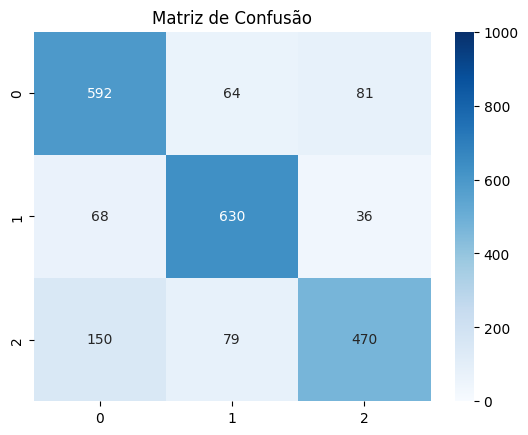

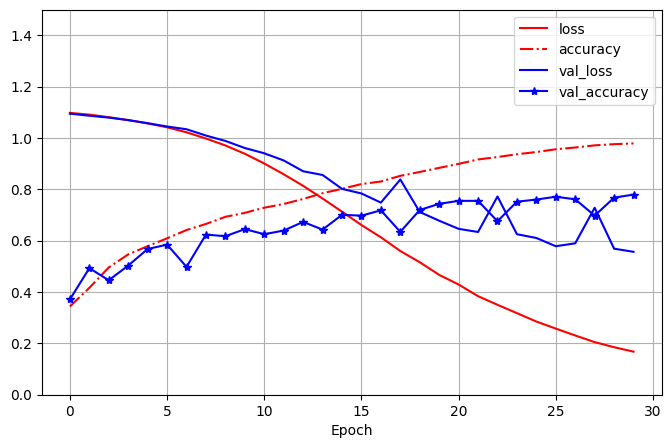

In [37]:
infos(model, history)

In [38]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=3, shuffle=True, random_state=42)
# 
# # Perform cross-validation
# for train_index, test_index in kf.split(finalFeature):
#     
#     X_train, X_test = finalFeature[train_index], finalFeature[test_index]
#     y_train, y_test = label[train_index], label[test_index]
#     X_train = X_train.toarray()
#     X_test = X_test.toarray()
#     model = create_model(1) 
#     model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))
#     loss, accuracy = model.evaluate(X_test, y_test)
#     print(f'Loss: {loss}, Accuracy: {accuracy}')

## glorot

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [39]:
model = create_model(2)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                255720    
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 3)                 33        
                                                                 
Total params: 255863 (999.46 KB)
Trainable params: 255863 (999.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/30
204/204 [==============================] - 8s 28ms/step - loss: 1.0969 - accuracy: 0.3527 - val_loss: 1.0931 - val_accuracy: 0.4115
Epoch 2/30
204/204 [==============================] - 4s 18ms/step - loss: 1.0878 - accuracy: 0.4396 - val_loss: 1.0830 - val_accuracy: 0.4931
Epoch 3/30
204/204 [==============================] - 4s 18ms/step - loss: 1.0759 - accuracy: 0.5127 - val_loss: 1.0738 - val_accuracy: 0.4839
Epoch 4/30
204/204 [==============================] - 4s 18ms/step - loss: 1.0624 - accuracy: 0.5478 - val_loss: 1.0635 - val_accuracy: 0.5097
Epoch 5/30
204/204 [==============================] - 3s 17ms/step - loss: 1.0478 - accuracy: 0.5831 - val_loss: 1.0494 - val_accuracy: 0.5710
Epoch 6/30
204/204 [==============================] - 3s 15ms/step - loss: 1.0309 - accuracy: 0.6143 - val_loss: 1.0357 - val_accuracy: 0.5604
Epoch 7/30
204/204 [==============================] - 3s 15ms/step - loss: 1.0115 - accuracy: 0.6292 - val_loss: 1.0221 - val_accuracy: 0.5585

68/68 [==============================] - 1s 17ms/step
Accuracy: 77.47
macro = 0.7722495
micro = 0.7746544


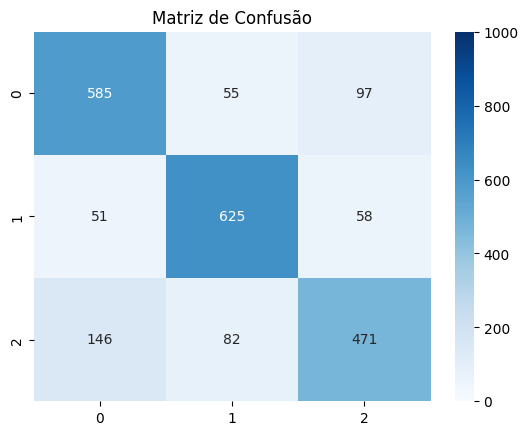

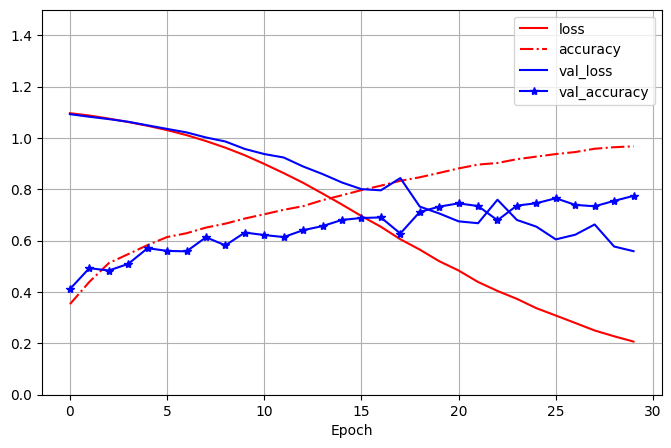

In [40]:
infos(model, history)

In [41]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=3, shuffle=True, random_state=42)
# 
# Perform cross-validation
# for train_index, test_index in kf.split(finalFeature):
#     
#     X_train, X_test = finalFeature[train_index], finalFeature[test_index]
#     y_train, y_test = label[train_index], label[test_index]
#     X_train = X_train.toarray()
#     X_test = X_test.toarray()
#     model = create_model(2) 
#     model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))
#     loss, accuracy = model.evaluate(X_test, y_test)
#     print(f'Loss: {loss}, Accuracy: {accuracy}')

## l2

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [42]:
model = create_model(3)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                255720    
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 3)                 33        
                                                                 
Total params: 255863 (999.46 KB)
Trainable params: 255863 (999.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/30
204/204 [==============================] - 9s 24ms/step - loss: 1.3696 - accuracy: 0.3449 - val_loss: 1.3562 - val_accuracy: 0.3378
Epoch 2/30
204/204 [==============================] - 3s 16ms/step - loss: 1.3436 - accuracy: 0.3871 - val_loss: 1.3303 - val_accuracy: 0.4714
Epoch 3/30
204/204 [==============================] - 3s 16ms/step - loss: 1.3184 - accuracy: 0.4642 - val_loss: 1.3084 - val_accuracy: 0.4488
Epoch 4/30
204/204 [==============================] - 3s 16ms/step - loss: 1.2950 - accuracy: 0.5094 - val_loss: 1.2875 - val_accuracy: 0.5032
Epoch 5/30
204/204 [==============================] - 3s 15ms/step - loss: 1.2738 - accuracy: 0.5515 - val_loss: 1.2672 - val_accuracy: 0.5396
Epoch 6/30
204/204 [==============================] - 3s 17ms/step - loss: 1.2541 - accuracy: 0.5700 - val_loss: 1.2493 - val_accuracy: 0.5447
Epoch 7/30
204/204 [==============================] - 3s 16ms/step - loss: 1.2347 - accuracy: 0.5954 - val_loss: 1.2353 - val_accuracy: 0.4585

68/68 [==============================] - 1s 6ms/step
Accuracy: 72.76
macro = 0.7254301
micro = 0.72764975


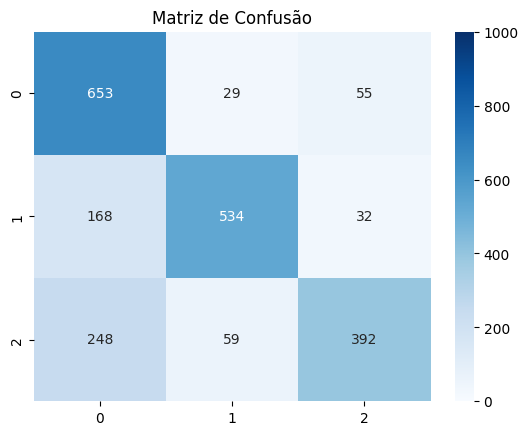

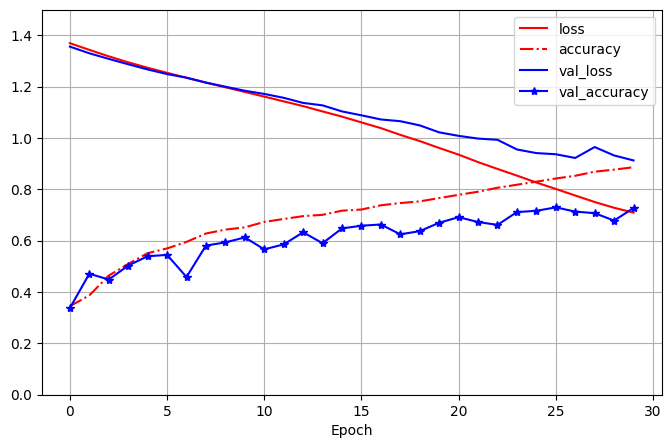

In [43]:
infos(model, history)

In [44]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=3, shuffle=True, random_state=42)
# 
# # Perform cross-validation
# for train_index, test_index in kf.split(finalFeature):
#     
#     X_train, X_test = finalFeature[train_index], finalFeature[test_index]
#     y_train, y_test = label[train_index], label[test_index]
#     X_train = X_train.toarray()
#     X_test = X_test.toarray()
#     model = create_model(3) 
#     model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100)
#     loss, accuracy = model.evaluate(X_test, y_test)
#     print(f'Loss: {loss}, Accuracy: {accuracy}')

## BatchNormalization

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [45]:
model = create_model(4)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 25571)             102284    
 Normalization)                                                  
                                                                 
 dense_9 (Dense)             (None, 10)                255720    
                                                                 
 batch_normalization_1 (Bat  (None, 10)                40        
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 batch_normalization_2 (Bat  (None, 10)                40        
 chNormalization)                                                
                                                      

Epoch 1/30
66/66 [==============================] - 9s 90ms/step - loss: 0.9612 - accuracy: 0.5716 - val_loss: 1.0746 - val_accuracy: 0.4065
Epoch 2/30
66/66 [==============================] - 4s 62ms/step - loss: 0.5176 - accuracy: 0.8333 - val_loss: 1.0429 - val_accuracy: 0.4258
Epoch 3/30
66/66 [==============================] - 4s 63ms/step - loss: 0.3461 - accuracy: 0.9120 - val_loss: 0.9859 - val_accuracy: 0.4802
Epoch 4/30
66/66 [==============================] - 4s 64ms/step - loss: 0.2279 - accuracy: 0.9594 - val_loss: 0.8992 - val_accuracy: 0.6410
Epoch 5/30
66/66 [==============================] - 6s 95ms/step - loss: 0.1551 - accuracy: 0.9811 - val_loss: 0.8051 - val_accuracy: 0.7341
Epoch 6/30
66/66 [==============================] - 4s 68ms/step - loss: 0.1095 - accuracy: 0.9923 - val_loss: 0.7055 - val_accuracy: 0.7590
Epoch 7/30
66/66 [==============================] - 5s 74ms/step - loss: 0.0767 - accuracy: 0.9969 - val_loss: 0.6765 - val_accuracy: 0.7332
Epoch 8/30
66

68/68 [==============================] - 2s 14ms/step
Accuracy: 73.27
macro = 0.7289254
micro = 0.7327189


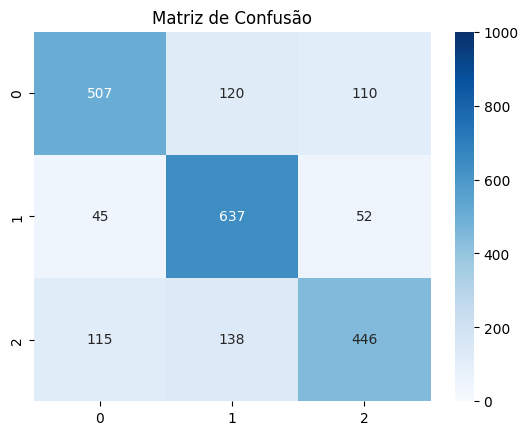

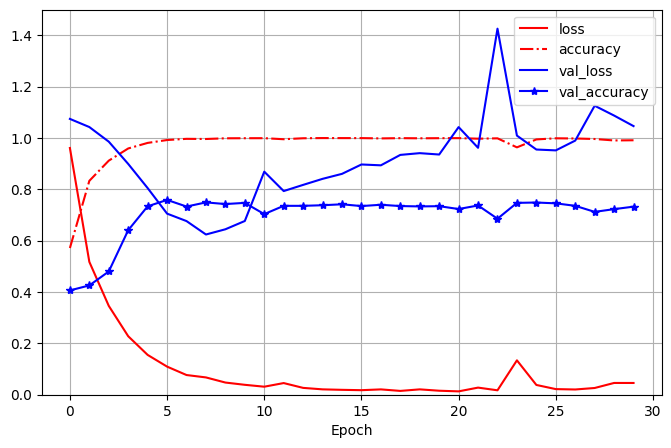

In [46]:
infos(model, history)

In [47]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=3, shuffle=True, random_state=42)
# 
# # Perform cross-validation
# for train_index, test_index in kf.split(finalFeature):
#     
#     X_train, X_test = finalFeature[train_index], finalFeature[test_index]
#     y_train, y_test = label[train_index], label[test_index]
#     X_train = X_train.toarray()
#     X_test = X_test.toarray()
#     model = create_model(4) 
#     model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))
#     loss, accuracy = model.evaluate(X_test, y_test)
#     print(f'Loss: {loss}, Accuracy: {accuracy}')

## Dropout

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [48]:
model = create_model(5)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 25571)             0         
                                                                 
 dense_12 (Dense)            (None, 10)                255720    
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                110       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_14 (Dense)            (None, 3)                 33        
                                                                 
Total params: 255863 (999.46 KB)
Trainable params: 255

Epoch 1/30
204/204 [==============================] - 12s 44ms/step - loss: 1.0968 - accuracy: 0.3607 - val_loss: 1.0942 - val_accuracy: 0.3627
Epoch 2/30
204/204 [==============================] - 7s 35ms/step - loss: 1.0897 - accuracy: 0.4049 - val_loss: 1.0858 - val_accuracy: 0.5065
Epoch 3/30
204/204 [==============================] - 7s 35ms/step - loss: 1.0803 - accuracy: 0.4419 - val_loss: 1.0787 - val_accuracy: 0.4461
Epoch 4/30
204/204 [==============================] - 7s 37ms/step - loss: 1.0685 - accuracy: 0.4813 - val_loss: 1.0670 - val_accuracy: 0.5484
Epoch 5/30
204/204 [==============================] - 7s 35ms/step - loss: 1.0551 - accuracy: 0.5069 - val_loss: 1.0537 - val_accuracy: 0.5728
Epoch 6/30
204/204 [==============================] - 7s 35ms/step - loss: 1.0427 - accuracy: 0.5376 - val_loss: 1.0420 - val_accuracy: 0.5820
Epoch 7/30
204/204 [==============================] - 7s 32ms/step - loss: 1.0235 - accuracy: 0.5601 - val_loss: 1.0428 - val_accuracy: 0.436

68/68 [==============================] - 1s 7ms/step
Accuracy: 76.27
macro = 0.7638723
micro = 0.7626727


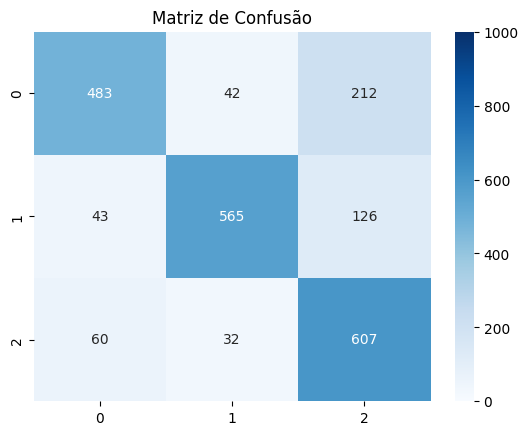

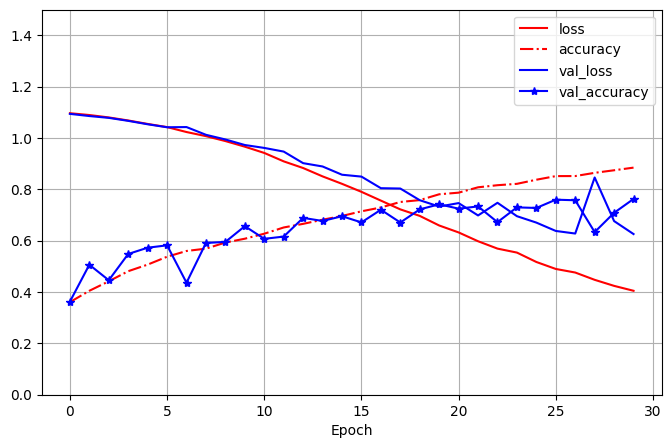

In [49]:
infos(model, history)

In [50]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=3, shuffle=True, random_state=42)
# 
# # Perform cross-validation
# for train_index, test_index in kf.split(finalFeature):
#     
#     X_train, X_test = finalFeature[train_index], finalFeature[test_index]
#     y_train, y_test = label[train_index], label[test_index]
#     X_train = X_train.toarray()
#     X_test = X_test.toarray()
#     model = create_model(5) 
#     model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))
#     loss, accuracy = model.evaluate(X_test, y_test)
#     print(f'Loss: {loss}, Accuracy: {accuracy}')

## tudo

In [51]:
model = create_model(6)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Bat  (None, 25571)             102284    
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 25571)             0         
                                                                 
 dense_15 (Dense)            (None, 10)                255720    
                                                                 
 batch_normalization_4 (Bat  (None, 10)                40        
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 10)                0         
                                                                 
 dense_16 (Dense)            (None, 10)               

68/68 [==============================] - 3s 23ms/step
Accuracy: 73.09
macro = 0.72844595
micro = 0.73087555


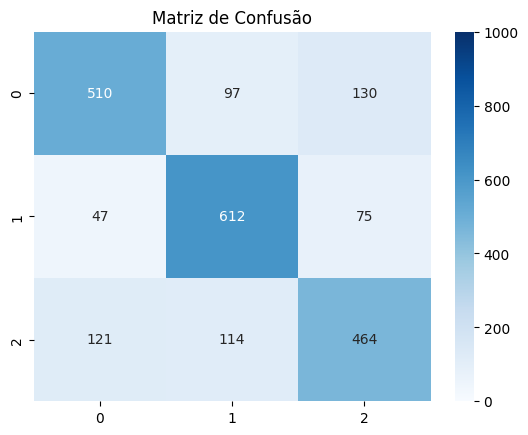

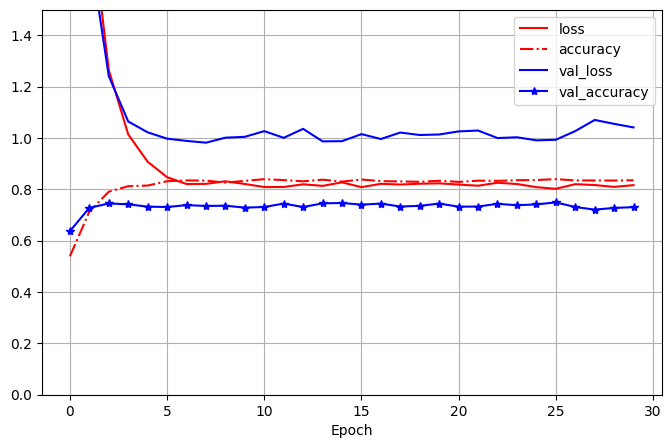

In [52]:
infos(model, history)

In [53]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=3, shuffle=True, random_state=42)
# 
# # Perform cross-validation
# for train_index, test_index in kf.split(finalFeature):
#     
#     X_train, X_test = finalFeature[train_index], finalFeature[test_index]
#     y_train, y_test = label[train_index], label[test_index]
#     X_train = X_train.toarray()
#     X_test = X_test.toarray()
#     model = create_model(6) 
#     model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))
#     loss, accuracy = model.evaluate(X_test, y_test)
#     print(f'Loss: {loss}, Accuracy: {accuracy}')

## tudo com exp_schedule

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [54]:
model = create_model(6)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=exp_schedule)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Bat  (None, 25571)             102284    
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 25571)             0         
                                                                 
 dense_18 (Dense)            (None, 10)                255720    
                                                                 
 batch_normalization_7 (Bat  (None, 10)                40        
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 10)                0         
                                                                 
 dense_19 (Dense)            (None, 10)               

Epoch 1/30
204/204 [==============================] - 15s 52ms/step - loss: 3.4146 - accuracy: 0.5392 - val_loss: 2.6684 - val_accuracy: 0.6373 - lr: 0.0100
Epoch 2/30
204/204 [==============================] - 9s 43ms/step - loss: 1.9280 - accuracy: 0.7149 - val_loss: 1.7870 - val_accuracy: 0.7276 - lr: 0.0090
Epoch 3/30
204/204 [==============================] - 9s 42ms/step - loss: 1.3011 - accuracy: 0.8032 - val_loss: 1.2833 - val_accuracy: 0.7498 - lr: 0.0082
Epoch 4/30
204/204 [==============================] - 9s 45ms/step - loss: 1.0277 - accuracy: 0.8293 - val_loss: 1.0867 - val_accuracy: 0.7456 - lr: 0.0074
Epoch 5/30
204/204 [==============================] - 10s 47ms/step - loss: 0.8842 - accuracy: 0.8450 - val_loss: 1.0199 - val_accuracy: 0.7419 - lr: 0.0067
Epoch 6/30
204/204 [==============================] - 9s 45ms/step - loss: 0.7897 - accuracy: 0.8637 - val_loss: 0.9744 - val_accuracy: 0.7452 - lr: 0.0061
Epoch 7/30
204/204 [==============================] - 10s 48ms

68/68 [==============================] - 1s 10ms/step
Accuracy: 76.04
macro = 0.756447
micro = 0.76036865


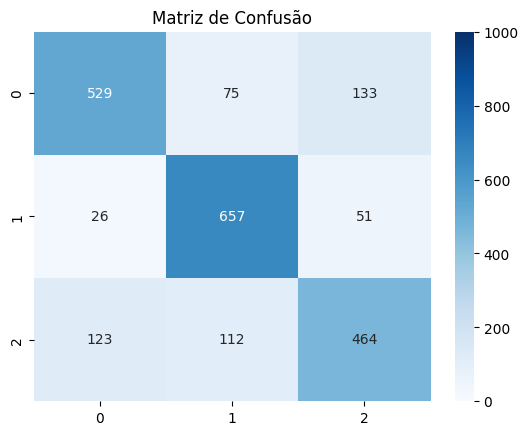

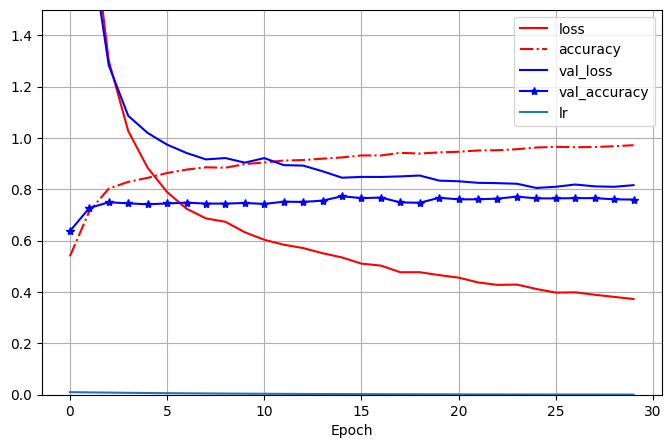

In [55]:
infos(model, history)

In [56]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=3, shuffle=True, random_state=42)
# 
# # Perform cross-validation
# for train_index, test_index in kf.split(finalFeature):
#     
#     X_train, X_test = finalFeature[train_index], finalFeature[test_index]
#     y_train, y_test = label[train_index], label[test_index]
#     X_train = X_train.toarray()
#     X_test = X_test.toarray()
#     model = create_model(6) 
#     model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=exp_schedule)
#     loss, accuracy = model.evaluate(X_test, y_test)
#     print(f'Loss: {loss}, Accuracy: {accuracy}')

## tudo com power_schedule

In [57]:
model = create_model(6)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=power_schedule, batch_size=100)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_9 (Bat  (None, 25571)             102284    
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 25571)             0         
                                                                 
 dense_21 (Dense)            (None, 10)                255720    
                                                                 
 batch_normalization_10 (Ba  (None, 10)                40        
 tchNormalization)                                               
                                                                 
 dropout_10 (Dropout)        (None, 10)                0         
                                                                 
 dense_22 (Dense)            (None, 10)               

Epoch 1/30
66/66 [==============================] - 13s 117ms/step - loss: 4.1005 - accuracy: 0.5002 - val_loss: 3.7058 - val_accuracy: 0.4479 - lr: 0.0100
Epoch 2/30
66/66 [==============================] - 7s 105ms/step - loss: 3.0883 - accuracy: 0.6836 - val_loss: 3.1236 - val_accuracy: 0.5594 - lr: 0.0098
Epoch 3/30
66/66 [==============================] - 7s 106ms/step - loss: 2.4893 - accuracy: 0.7508 - val_loss: 2.6690 - val_accuracy: 0.6816 - lr: 0.0096
Epoch 4/30
66/66 [==============================] - 7s 103ms/step - loss: 2.0204 - accuracy: 0.8184 - val_loss: 2.3136 - val_accuracy: 0.7392 - lr: 0.0094
Epoch 5/30
66/66 [==============================] - 7s 101ms/step - loss: 1.6820 - accuracy: 0.8484 - val_loss: 2.0250 - val_accuracy: 0.7304 - lr: 0.0092
Epoch 6/30
66/66 [==============================] - 6s 98ms/step - loss: 1.4242 - accuracy: 0.8759 - val_loss: 1.7691 - val_accuracy: 0.7465 - lr: 0.0090
Epoch 7/30
66/66 [==============================] - 7s 111ms/step - lo

68/68 [==============================] - 1s 11ms/step
Accuracy: 74.19
macro = 0.73834866
micro = 0.7419355


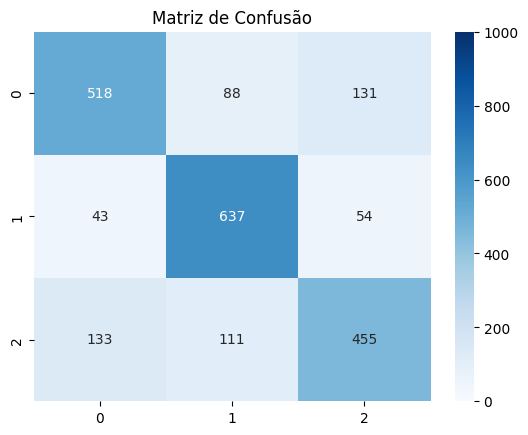

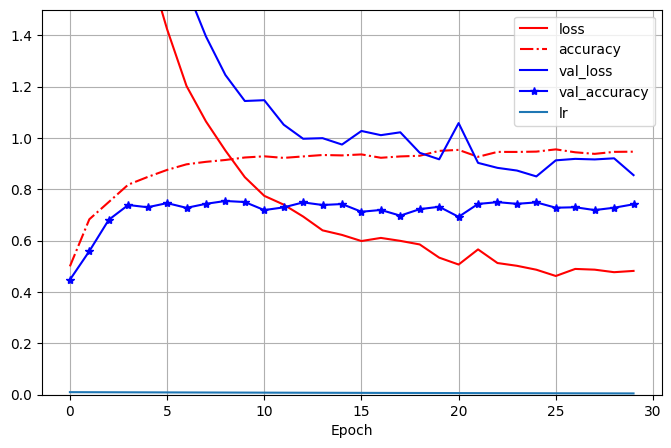

In [58]:
infos(model, history)

In [59]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=3, shuffle=True, random_state=42)
# 
# # Perform cross-validation
# for train_index, test_index in kf.split(finalFeature):
#     
#     X_train, X_test = finalFeature[train_index], finalFeature[test_index]
#     y_train, y_test = label[train_index], label[test_index]
#     X_train = X_train.toarray()
#     X_test = X_test.toarray()
#     model = create_model(6) 
#     model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=power_schedule)
#     loss, accuracy = model.evaluate(X_test, y_test)
#     print(f'Loss: {loss}, Accuracy: {accuracy}')